In [18]:
import sys, numpy as np
print("python:", sys.executable)
print("numpy :", np.__version__)


python: /home/hyuksu/projects/ml/.venv/bin/python
numpy : 1.26.4


In [19]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [20]:
import tensorflow_datasets as tfds

In [21]:
import tensorflow_datasets as tfds

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    "oxford_flowers102",
    split=["train", "validation", "test"],
    as_supervised=True,   # (image, label)
    with_info=True
)


In [5]:
#r객체 batch size지정
train=ds_train.batch(32)
test=ds_test.batch(32)
valid=ds_val.batch(32)
# 객체 pixel 조정
train


<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [22]:
import tensorflow as tf
from tensorflow.keras.applications.convnext import preprocess_input
s=(224,224)
def resize(x,y):
    x=tf.image.resize(x,s)
    return x,y

def float_t(x,y):
    x=tf.cast(x,tf.float32)
    return x,y

def transform(x,y):
    x=resize(x,y)
    x=float_t(x,y)
    x=preprocess_input(x)
    return x,y
    

In [23]:
import tensorflow as tf
from tensorflow.keras.applications.convnext import preprocess_input

IMG_SIZE = (224, 224)

def transform(x, y):
    x = tf.image.resize(x, IMG_SIZE)
    x = tf.cast(x, tf.float32)
    x = preprocess_input(x)  # 이미지에만!
    return x, y


In [24]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH = 32

train = (ds_train
         .map(transform, num_parallel_calls=AUTOTUNE)
         .shuffle(1000)
         .batch(BATCH)
         .prefetch(AUTOTUNE))

valid = (ds_val
         .map(transform, num_parallel_calls=AUTOTUNE)
         .batch(BATCH)
         .prefetch(AUTOTUNE))

test = (ds_test
        .map(transform, num_parallel_calls=AUTOTUNE)
        .batch(BATCH)
        .prefetch(AUTOTUNE))


In [25]:
x, y = next(iter(train))
print(x.shape, x.dtype)  # (32, 224, 224, 3) float32
print(y.shape, y.dtype)  

2026-01-18 21:20:45.681033: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


(32, 224, 224, 3) <dtype: 'float32'>
(32,) <dtype: 'int64'>


In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,InputLayer,Dropout,Flatten
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.models import Sequential

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ConvNeXtTiny

# 1) backbone: pooling=None 으로 feature map 유지
base_model = ConvNeXtTiny(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling=None
)
base_model.trainable = False

class SpatialAttentionPooling(layers.Layer):
    """
    Attention-weighted global pooling.
    - 입력: (B, H, W, C)
    - 출력: (B, C)
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # 1x1 conv로 attention logit 생성 (B,H,W,1)
        self.att_conv = layers.Conv2D(1, kernel_size=1, padding="same")

    def call(self, x):
        # x: (B,H,W,C)
        att_logits = self.att_conv(x)  # (B,H,W,1)

        # (B, H*W, 1)로 펴고 softmax로 공간 가중치 만들기
        b = tf.shape(att_logits)[0]
        h = tf.shape(att_logits)[1]
        w = tf.shape(att_logits)[2]

        att_flat = tf.reshape(att_logits, [b, h*w, 1])          # (B, HW, 1)
        att_weights = tf.nn.softmax(att_flat, axis=1)           # (B, HW, 1)

        # feature도 (B, HW, C)로 펴서 가중합
        feat_flat = tf.reshape(x, [b, h*w, tf.shape(x)[-1]])     # (B, HW, C)
        pooled = tf.reduce_sum(feat_flat * att_weights, axis=1)  # (B, C)

        return pooled

# 2) Functional API로 모델 구성 (Sequential로는 커스텀 pooling 넣기 불편해서)
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs)                 # (B, H, W, C)
x = SpatialAttentionPooling()(x)       # (B, C)

# 3) 네가 쓰던 classifier head
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(102, activation="softmax")(x)

transition_conv = Model(inputs, outputs, name="convnext_attention_pooling")
transition_conv.summary()


Model: "convnext_attention_pooling"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_attention_pooling       │ (None, 768)            │           769 │
│ (SpatialAttentionPooling)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 102)            │        26,214 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,978,567 (106.73 MB)

 Trainable params: 158,439 (618.90 KB)

 Non-trainable params: 27,820,128 (106.13 MB)

In [12]:
#학습방법
transition_conv.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
history=transition_conv.fit(train, validation_data=valid, epochs=30)

Epoch 1/30


2026-01-18 14:12:27.249972: I external/local_xla/xla/service/service.cc:163] XLA service 0x768a74006870 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-18 14:12:27.249995: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1768713147.256263    5753 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 226s 7s/step - accuracy: 0.0333 - loss: 4.5479 - val_accuracy: 0.1265 - val_loss: 4.1754
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 217s 7s/step - accuracy: 0.1931 - loss: 3.6611 - val_accuracy: 0.3010 - val_loss: 3.0934
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 208s 7s/step - accuracy: 0.3961 - loss: 2.5311 - val_accuracy: 0.3873 - val_loss: 2.4001
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 223s 7s/step - accuracy: 0.5451 - loss: 1.7954 - val_accuracy: 0.5029 - val_loss: 1.9432
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 218s 7s/step - accuracy: 0.6676 - loss: 1.2687 - val_accuracy: 0.5657 - val_loss: 1.6853
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 211s 7s/step - accuracy: 0.7775 - loss: 0.8915 - val_accuracy: 0.5941 - val_loss: 1.5581
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 243s 8s/step - accuracy: 0.8069 - loss: 0.7207 - val_accuracy: 0.5961 - val_loss: 1.5757
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 176s 6s/step - accuracy: 0.8549 - loss: 0.5472 - val_accuracy: 0.6235 - val_loss: 1.

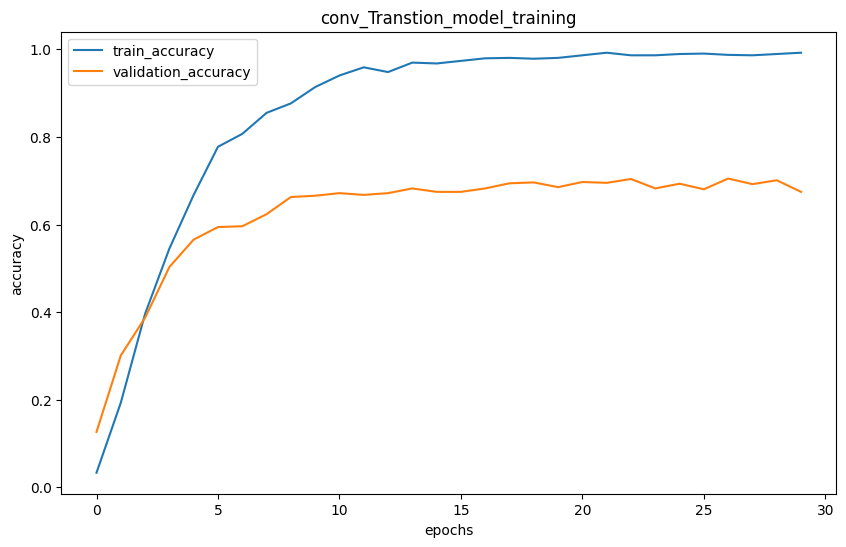

In [14]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='validation_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('conv_Transtion_model_training')
plt.legend()
plt.show()

In [ ]:
transition_conv.save('/home/hyuksu/projects/ml/deeplearning study/cnn_p/model/convnexttiny_transition_model.keras') 

In [16]:
transition_conv.evaluate(test)

2026-01-18 16:18:25.599818: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


193/193 ━━━━━━━━━━━━━━━━━━━━ 584s 3s/step - accuracy: 0.6586 - loss: 1.5623


[1.5623388290405273, 0.6586436629295349]

In [18]:
train_num=ds_info.splits["train"].num_examples
valid_num=ds_info.splits["validation"].num_examples
test_num=ds_info.splits["test"].num_examples

In [21]:
print(f'train:{train_num}\n valid:{valid_num}\n test:{test_num}')

train:1020
 valid:1020
 test:6149


label id: 72
class name: water lily


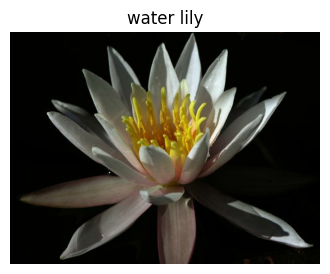

In [7]:
import matplotlib.pyplot as plt
image, label = next(iter(ds_train))
class_names = ds_info.features["label"].names
print("label id:", label.numpy())
print("class name:", class_names[label.numpy()])
plt.figure(figsize=(4,4))
plt.imshow(image.numpy())
plt.title(class_names[label.numpy()])
plt.axis("off")
plt.show()


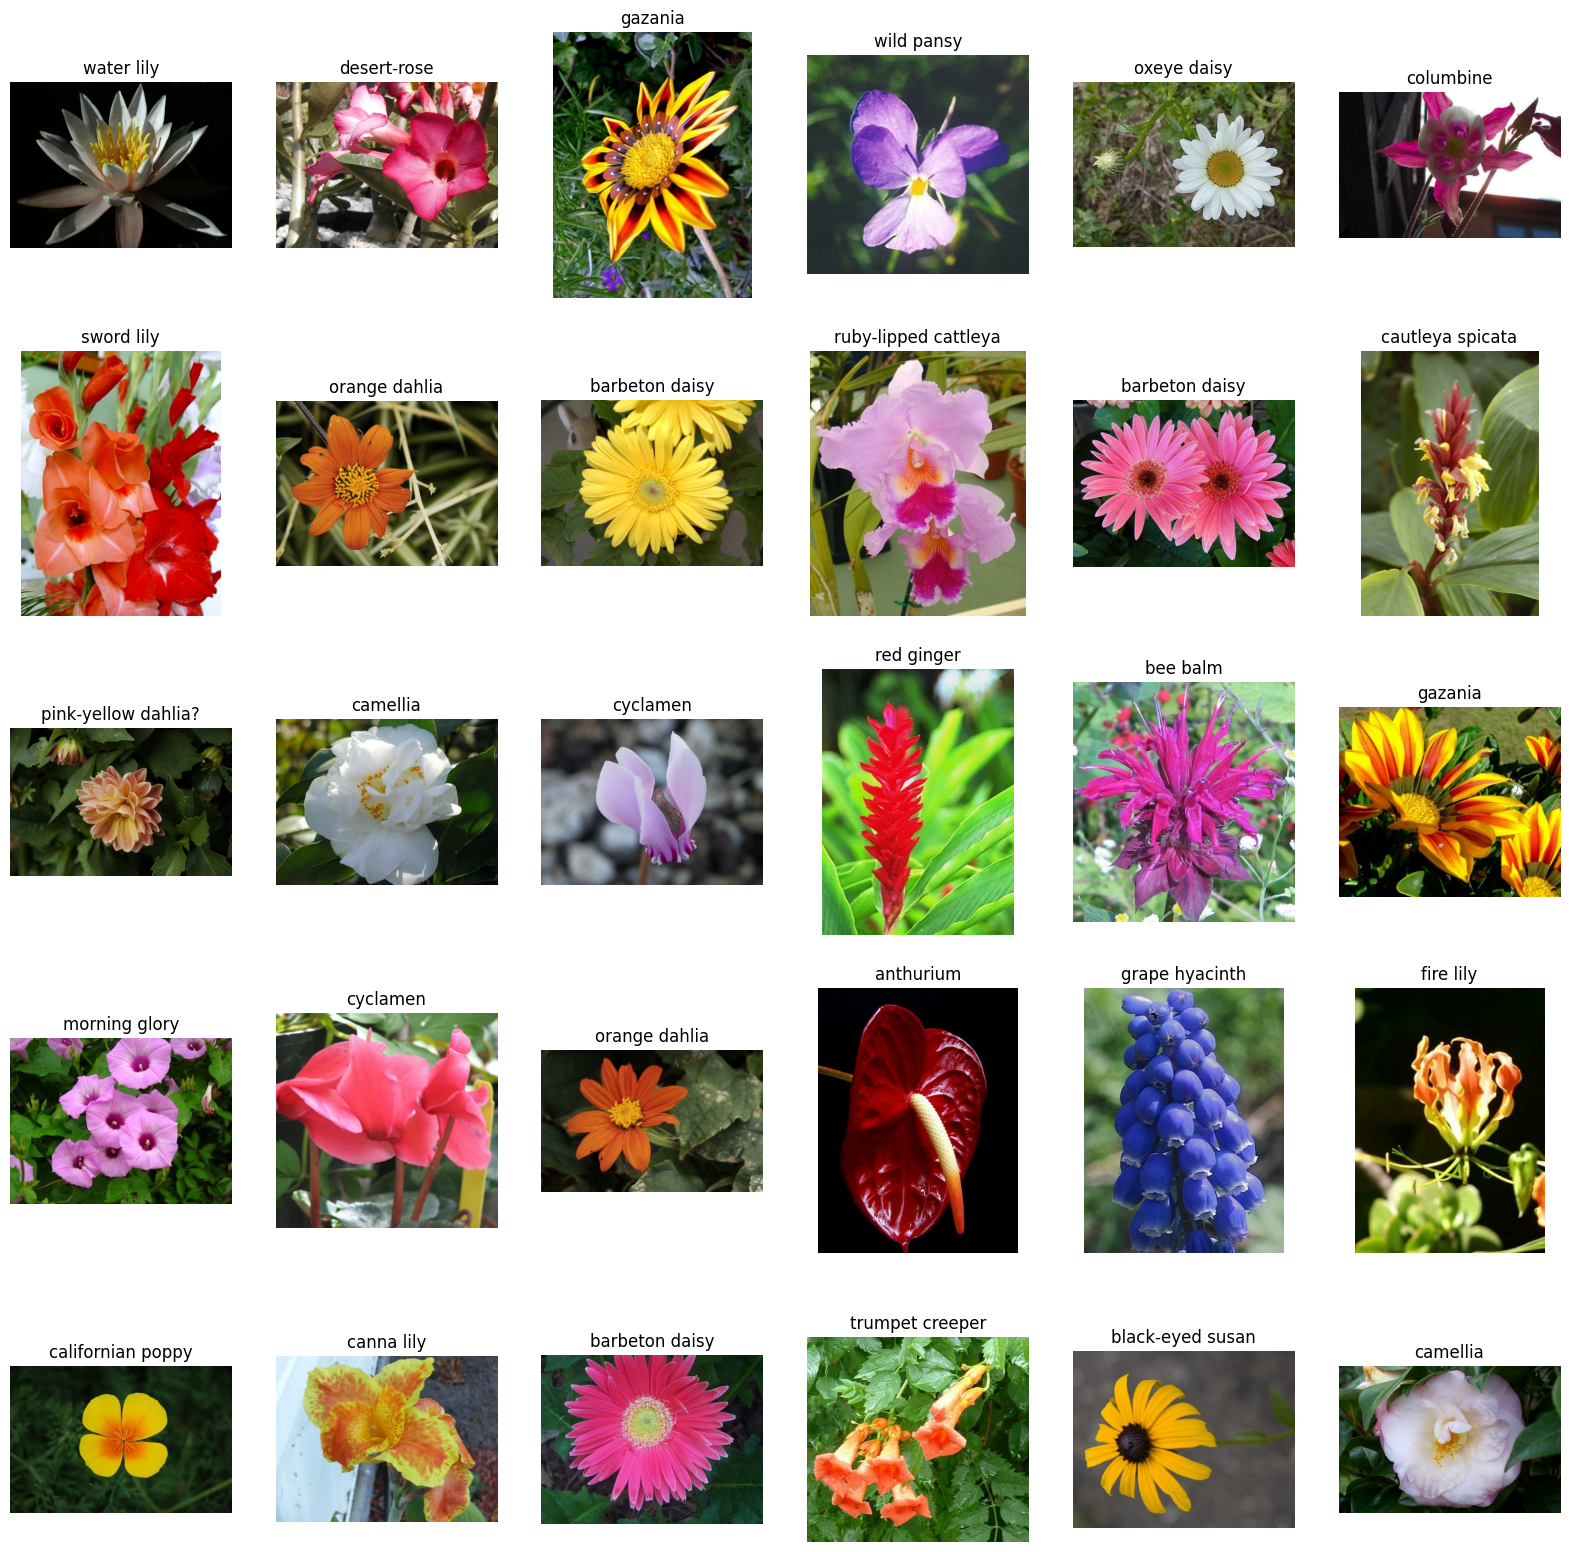

In [8]:
plt.figure(figsize=(20,20))

for i, (image, label) in enumerate(ds_train.take(30)):
    plt.subplot(5, 6, i+1)
    plt.imshow(image.numpy())
    plt.title(class_names[label.numpy()])
    plt.axis("off")

plt.show()


In [14]:
import tensorflow as tf

# 사용 가능한 GPU 목록 확인
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Intel GPU가 인식되었습니다: {gpus}")
else:
    print("GPU를 찾을 수 없습니다. (CPU만 사용 중)")

GPU를 찾을 수 없습니다. (CPU만 사용 중)


In [7]:
import keras
from keras import layers
import tensorflow as tf

@keras.saving.register_keras_serializable(package="Custom")
class SpatialAttentionPooling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.att_conv = layers.Conv2D(1, kernel_size=1, padding="same")

    def call(self, x):
        att_logits = self.att_conv(x)
        b = tf.shape(att_logits)[0]
        h = tf.shape(att_logits)[1]
        w = tf.shape(att_logits)[2]

        att_flat = tf.reshape(att_logits, [b, h*w, 1])
        att_weights = tf.nn.softmax(att_flat, axis=1)

        feat_flat = tf.reshape(x, [b, h*w, tf.shape(x)[-1]])
        pooled = tf.reduce_sum(feat_flat * att_weights, axis=1)
        return pooled

    def get_config(self):
        return super().get_config()


In [15]:
import tensorflow as tf
import keras
from keras import layers

class SpatialAttentionPooling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.att_conv = layers.Conv2D(1, kernel_size=1, padding="same")

    def call(self, x):
        att_logits = self.att_conv(x)
        b = tf.shape(att_logits)[0]
        h = tf.shape(att_logits)[1]
        w = tf.shape(att_logits)[2]
        att_flat = tf.reshape(att_logits, [b, h*w, 1])
        att_weights = tf.nn.softmax(att_flat, axis=1)
        feat_flat = tf.reshape(x, [b, h*w, tf.shape(x)[-1]])
        return tf.reduce_sum(feat_flat * att_weights, axis=1)

model = keras.saving.load_model(
    "/home/hyuksu/projects/ml/deeplearning study/cnn_p/model/convnexttiny_transition_model.keras",
    custom_objects={"SpatialAttentionPooling": SpatialAttentionPooling},
    compile=False,
)

model.summary()


/home/hyuksu/projects/ml/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'spatial_attention_pooling', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "convnext_attention_pooling"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_attention_pooling       │ (None, 768)            │           769 │
│ (SpatialAttentionPooling)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 102)            │        26,214 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,978,567 (106.73 MB)

 Trainable params: 158,439 (618.90 KB)

 Non-trainable params: 27,820,128 (106.13 MB)

In [16]:
model.save("/home/hyuksu/projects/ml/deeplearning study/cnn_p/model/convnexttiny_transition_model_fixed.keras")


In [31]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [32]:
model.evaluate(valid)

32/32 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.6745 - loss: 1.4922


[1.4922337532043457, 0.6745098233222961]